In [1]:
%matplotlib inline

In [2]:
from astropy.coordinates import GCRS, CartesianRepresentation, ITRS, SphericalRepresentation
from scipy import stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from poliastro.bodies import Earth
from astropy import units as u, time
from notebooks.PlotUtil import apply_report_formatting


figures_dir = 'D:/git/thesis_report_ae/figures/visibility_analysis'

def generate_pass_df(instance_df):
    starts = instance_df.groupby(['p', 'strand_name'], as_index = False).first(1)
    starts.index.name = 'p'
    starts.rename(columns= {'tof': 'start_tof'}, inplace=True)
    ends = instance_df.groupby(['p', 'strand_name'], as_index = False).last(1)
    ends.index.name = 'p'
    ends.rename(columns= {'tof': 'end_tof'}, inplace=True)

    pass_df = pd.concat([starts, ends.end_tof], axis=1)
    pass_df['duration'] = pass_df['end_tof'] - pass_df['start_tof']

    pass_df['r_b_norm'] = np.sqrt(pass_df['r_b_x']**2 + pass_df['r_b_y']**2 + pass_df['r_b_z']**2)

    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + pass_df['start_tof'].values * u.s

    gcrs_xyz = GCRS(x=pass_df['r_a_x'], y=pass_df['r_a_y'], z=pass_df['r_a_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    pass_df['r_a_lat'] = itrs_latlon.lat.to(u.deg)
    pass_df['r_a_lon'] = itrs_latlon.lon.to(u.deg)

    return pass_df

def generate_gap_df(instances_df, step_duration = 1.0, end_tof = None):

    unique_tofs = instances_df['tof'].unique()
    gap_indexes = np.squeeze(np.argwhere(np.diff(unique_tofs) > 1.5 * step_duration))

    start_tof = unique_tofs[gap_indexes]
    end_tof = unique_tofs[gap_indexes + 1]
    duration = end_tof - start_tof
    gaps_dict = {'start_tof': start_tof,
                'end_tof': end_tof,
                'duration': duration}

    return pd.DataFrame(gaps_dict)

# Telesat

In [3]:
columns = ['strand_name', 'tof', 'r_a_x', 'r_a_y', 'r_a_z', 'r_b_x', 'r_b_y', 'r_b_z']

store_500km = pd.HDFStore("Test_LOSAnalysis_sat_500km_90deg_to_Telesat_2020-12-31_08-50-39.h5")
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns))

In [4]:
store_400km = pd.HDFStore("Test_LOSAnalysis_sat_400km_51deg_to_Telesat_2020-12-31_08-50-33.h5")
instances_400km_df = store_400km.select('contact_instances', 'columns = %s' % str(columns))

In [5]:
pass_500km_df = generate_pass_df(instances_500km_df)
gaps_500km_df = generate_gap_df(instances_500km_df)

pass_400km_df = generate_pass_df(instances_400km_df)
gaps_400km_df = generate_gap_df(instances_400km_df)

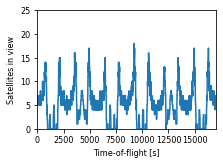

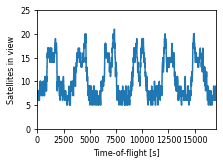

In [6]:
def contact_timeline(pass_df):
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    tof_max = 3*5677.0

    tofs = np.arange(tof_max)

    def satellites_in_view(pass_df, tofs):
        num_in_view = []
        for tof in tofs:
            in_view = (pass_df['start_tof'] <= tof) & (tof <= pass_df['end_tof'])
            num_in_view.append(in_view.sum())
        return num_in_view

    ax.plot(tofs, satellites_in_view(pass_df, tofs))
    ax.set_xlim((0, tof_max))
    ax.set_ylim((0, 25))
    ax.set_xlabel('Time-of-flight [s]')
    ax.set_ylabel('Satellites in view')
    #plt.show()

contact_timeline(pass_500km_df)
apply_report_formatting()
#plt.tight_layout()
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.svg')
plt.show()

contact_timeline(pass_400km_df)
apply_report_formatting()
#plt.tight_layout()
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.pgf')
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.svg')
plt.show()


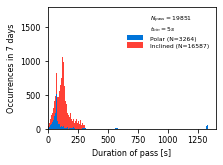

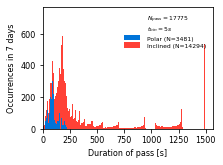

In [7]:
def plot_pass_temporal_distribution(pass_df, bin_size = 5.0):

    durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{pass} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    # Split into polar and inclined orbits
    polar_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1015*1000)
    inc_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1325*1000)

    durations_np = [durations_np[polar_sat], durations_np[inc_sat]]

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               histtype='bar',
                               stacked=True,
                               color=["#0074D9", "#FF4136"],
                               label=['Polar (N=%d)' % polar_sat.sum(),
                                      'Inclined (N=%d)' % inc_sat.sum()])

    ax.set_xlabel('Duration of pass [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.set_xlim((0, ax.get_xlim()[1]))

    #average = np.average(durations_np)
    #std_dev = np.std(durations_np)

    # ax.text(0.5, 0.90,
    #         '$N_{pass} = %d$\n' % (count) +
    #         '$t_{bin} = %ds$' % (bin_size),
    #      horizontalalignment='left',
    #      verticalalignment='top',
    #      transform = ax.transAxes)



    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

plot_pass_temporal_distribution(pass_500km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_500km97deg.pgf')
plt.show()

plot_pass_temporal_distribution(pass_400km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_400km51deg.pgf')
plt.show()

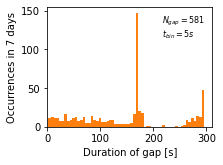

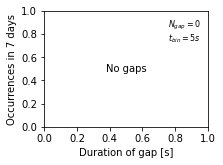

In [8]:
def plot_gap_temporal_distribution(gaps_df, bin_size = 5.0):

    durations_np = gaps_df.duration.to_numpy()
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{gap} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    ax.set_xlabel('Duration of gap [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

    if len(durations_np) == 0:
        ax.text(0.5, 0.50,
            'No gaps',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))

        return

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               stacked=True,
                               color = "tab:orange",
                               lw=0,
                               label='Gaps')


    ax.set_xlim((0, ax.get_xlim()[1]))

    average = np.average(durations_np)
    std_dev = np.std(durations_np)

plot_gap_temporal_distribution(gaps_500km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_500km97deg.pgf')
plt.show()

plot_gap_temporal_distribution(gaps_400km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_400km51deg.pgf')
plt.show()

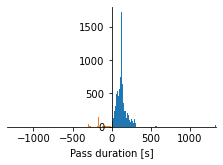

In [9]:
def plot_pass_gap_temporal_distribution(pass_df, gap_df, bin_size = 5.0):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    pass_durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(pass_durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(pass_durations_np, bins=bins, stacked=True)

    gap_durations_np = gap_df.duration.to_numpy()

    bins = int(np.max(gap_durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(-1*gap_durations_np, bins=bins, stacked=True)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(max(pass_durations_np.max(), gap_durations_np.max()) * np.array([-1, 1]))
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel('Pass duration [s]')
    #ax.set_xticks(abs(ax.get_xticks()))
    #ax.set_xticklabels([''] + str(abs(ax.get_xticks())))

plot_pass_gap_temporal_distribution(pass_500km_df, gaps_500km_df)
pass

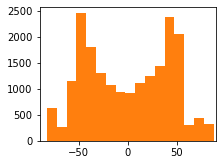

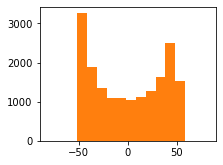

In [10]:
def plot_pass_spatial_occurance_distribution(pass_df):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    llat = pass_df['r_a_lat']

    bin_width = 10
    bins_llat = np.arange(min(llat), max(llat) + bin_width, bin_width)

    n, bins, patches = ax.hist(llat,
                            stacked=True,
                            #density=True,
                            bins=bins_llat,
                            color = "tab:orange",
                            lw=0,
                            label='Gaps')

    ax.set_xlim((-90, 90))


plot_pass_spatial_occurance_distribution(pass_500km_df)
plt.show()

plot_pass_spatial_occurance_distribution(pass_400km_df)
plt.show()

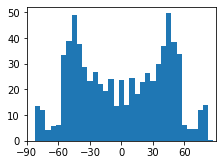

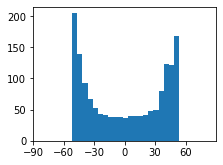

In [11]:
def plot_pass_spatial_temporal_distribution(pass_df):

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    llat = pass_df['r_a_lat']
    durations = pass_df['duration']

    bin_width = 5
    bins_llat = np.arange(min(llat), max(llat) + bin_width, bin_width)

    bin_min, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='min', bins=bins_llat)

    bin_mean, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='mean', bins=bins_llat)

    bin_max, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='max', bins=bins_llat)

    bin_sum, bin_edges, binnumber = stats.binned_statistic(
                llat,
                durations,
                statistic='sum', bins=bins_llat)
    bin_sum = bin_sum / 60 / 60

    x = (bin_edges[:-1] + bin_edges[1:])/2
    w = bin_edges[1:] - bin_edges[:-1]
    ax.bar(x, bin_sum, w)

    ax.set_xticks(np.arange(-90, 90, 30))

    #ax.hlines(bin_sum, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
    #           label='binned statistic of data')
    #ax.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_sum)
    #
    # y = bin_mean
    #
    # y_pos = bin_max - bin_mean
    # y_neg = -1*(bin_mean - bin_min)
    # plt.errorbar(x, y, yerr=np.array([-1*y_neg, y_pos]),
    #          label='uplims=True, lolims=True')

    ax.set_xlim((-90, 90))

plot_pass_spatial_temporal_distribution(pass_500km_df)
plt.show()

plot_pass_spatial_temporal_distribution(pass_400km_df)
plt.show()

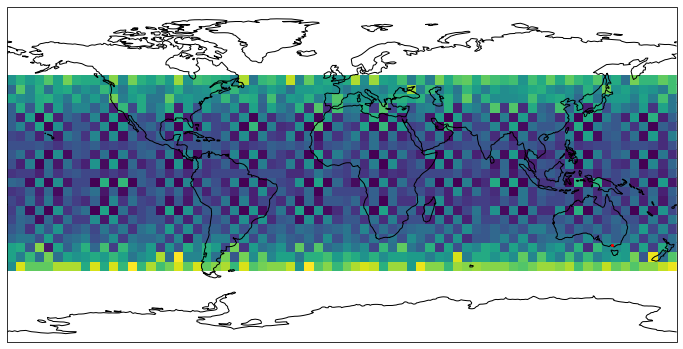

In [12]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.plot(145.014659, -37.785922,  markersize=2, marker='o', color='red', transform=ccrs.PlateCarree())

pass_df = pass_500km_df
pass_df = pass_400km_df
llat = pass_df['r_a_lat']
llon = pass_df['r_a_lon']

bin_width = 5.0
bins_llon = np.arange(min(llon), max(llon) + bin_width, bin_width)
bins_llat = np.arange(min(llat), max(llat) + bin_width, bin_width)

ax.hist2d(llon, llat, bins=[bins_llon, bins_llat])

ax.set_extent([-180, 180, -90, 90])
plt.show()